In [1]:

from pypower.api import loadcase, runopf, ppoption
from pypower.idx_brch import *
from pypower.idx_bus import *
from pypower.idx_gen import *
from pypower.idx_cost import *
from pypower.ext2int import ext2int
import oct2py
import numpy as np
from numpy import r_
import math
import os, sys
from tqdm import tqdm
from oct2py import Oct2Py
octave = Oct2Py()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
import shutil
import cvxpy as cp
from contextlib import contextmanager
import warnings
import cyipopt
from problemDef import opfSocp
from copy import deepcopy
# suppress ComplexWarning
warnings.simplefilter("ignore", np.ComplexWarning)
# check for latex and configure matplotlib accordingly
if shutil.which('latex') is None:
    LATEX_AVAILABLE = False
else:
    LATEX_AVAILABLE = True
if LATEX_AVAILABLE:
    plt.rcParams['font.size'] = 14
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'

# to suppress output from functions    
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout    

# user options 
MAX_BUS = 10000 # upper limit of number of buses in cases to be considered
RATE = 'A' # which line rating to use ('A','B','C')

In [2]:
# To use SPRAL, use the following commands
# export SPRALDIR=${HOME}/Software/spral/build
# export OMP_CANCELLATION=TRUE
# export OMP_PROC_BIND=TRUE

In [3]:
# get all cases in current directory
current_directory = os.getcwd()+'/'
# current_directory = '/home/sbose/pglib-opf/' # for running on BEBOP
all_files_and_directories = os.listdir(current_directory)
case_files = [os.path.join(current_directory, f) for f in all_files_and_directories if f.endswith('.m') and os.path.isfile(os.path.join(current_directory, f))]

cases, casenames = [], []
cases_full, casenames_full = [], []
for cf in (t:=tqdm(case_files)):
    with suppress_stdout():
        octave.source(current_directory+os.path.basename(cf))
    cname = os.path.basename(cf).split('.')[0]
    num_buses = None
    # determine number of buses in the case from its name
    for ci in cname.split('_'):
        if 'case' in ci:
            num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
    # fitler out cases with more buses than MAX_BUS
    if num_buses <= MAX_BUS:
        # convert to internal indexing
        case_correct_idx = ext2int(loadcase(octave.feval(cname)))
        # append
        cases.append(case_correct_idx)
        casenames.append(cname)
    t.set_description(cname)

pglib_opf_case793_goc: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:16<00:00,  3.41it/s]


  0%|                                                                                                                                                                                                                                      | 0/58 [00:00<?, ?it/s]OMP: Info #268: OMP_NESTED variable deprecated, please use OMP_MAX_ACTIVE_LEVELS instead.


Solving pglib_opf_case60_c.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver spral.

Number of nonzeros in equality constraint Jacobian...:     1861
Number of nonzeros in inequality constraint Jacobian.:     1056
Number of nonzeros in Lagrangian Hessian.............:      600

Total number of variables............................:      633
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      633
                     variables with only upper bounds:        0
Total number of equality constraints.................:      472
Total 

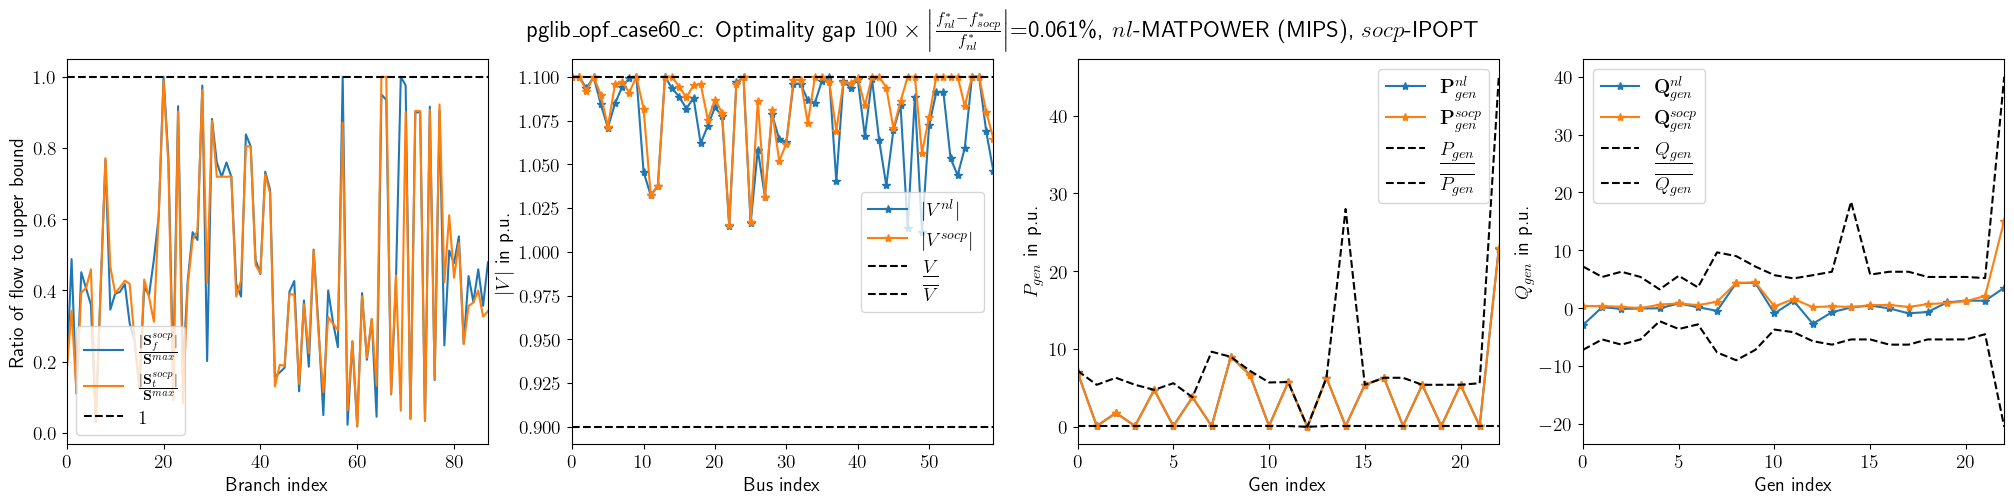

  2%|███▊                                                                                                                                                                                                                          | 1/58 [00:02<02:08,  2.26s/it]

Solving pglib_opf_case3120sp_k.
This is Ipopt version 3.14.14, running with linear solver spral.

Number of nonzeros in equality constraint Jacobian...:    80522
Number of nonzeros in inequality constraint Jacobian.:    44316
Number of nonzeros in Lagrangian Hessian.............:    25842

Total number of variables............................:    25736
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    25736
                     variables with only upper bounds:        0
Total number of equality constraints.................:    21012
Total number of inequality constraints...............:    18465
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:    18465

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1455062e+04 1.47e+02 1.00e+02   0.0 0.00e+0

In [4]:
# RECORDS FOR SOLVED AND UNSOLVED
solved, unsolved = 0,0

# FUNCTIONS TO COMPUTE ABSOLUTE VALUES # TEST
absobj = lambda x,y: cp.sum(cp.hstack([cp.abs(cp.real(x)),cp.abs(cp.imag(x)),cp.abs(cp.real(y)),cp.abs(cp.imag(y))]))

iterlist = [itm for itm in zip(casenames,cases)]
for cn,this_case in tqdm(iterlist):
    
    # Initialize
    print(f"Solving {cn}.")
    optObj = opfSocp(this_case,cn)
    cub, clb = optObj.calc_cons_bounds()
    xub, xlb = optObj.calc_var_bounds()
    
    # Define IPOPT problem
    prob = cyipopt.Problem(
        n = optObj.in_size,
        m = optObj.cons_size,
        problem_obj=optObj,
        lb=xlb,
        ub=xub,
        cl=clb,
        cu=cub
    )
    
    # Setup solver options
    prob.add_option('tol',1e-6)
    # prob.add_option('max_iter',20)
    prob.add_option('mu_strategy','adaptive')
    # prob.add_option('mu_init',1e-4)
    # prob.add_option('mumps_mem_percent',10000)
    prob.add_option('nlp_lower_bound_inf',-optObj.LARGE_NUMBER+1)
    prob.add_option('linear_solver','spral')
    # prob.add_option('jac_c_constant','yes')
    # prob.add_option('hessian_constant','yes')
    # prob.add_option('least_square_init_primal','yes')
    # prob.add_option('least_square_init_duals','yes')
    # prob.add_option('derivative_test','second-order')
    
    # load stored MATPOWER solution (referred to as 'nonlinear')
    with open(f"{current_directory}/{cn}_solved.pkl","rb") as file:
        obj = pickle.load(file)
        obj = ext2int(obj)
    
    # Solve ipopt problem
    x, info = prob.solve(optObj.calc_x0(obj))
    
    # restore variables
    U, W, Sg, Sf, St = optObj.vars_calculator(x)
    
    # pickle results
    with open(f"{current_directory}/{cn}_socp_solved.pkl","wb") as file:
        pickle.dump({'x':x,'U':U,'W':W,'Sg':Sg,'Sf':Sf,'St':St},file)
    
    # plot
    solved += 1
    # calculate soc objective in natural units
    soc_pg, nl_pg = Sg.real, obj['gen'][:,PG] / optObj.baseMVA
    obj_soc, obj_nl = 0, 0
    for gidx in range(optObj.n_gen):
        if np.abs(optObj.gen_cost[gidx,0]) > 1e-5: # quadratic cost
            obj_soc = obj_soc + optObj.gen_cost[gidx,0]*soc_pg[gidx]**2
            obj_nl = obj_nl + optObj.gen_cost[gidx,0]*nl_pg[gidx]**2
        if np.abs(optObj.gen_cost[gidx,1]) > 1e-5: # linear cost
            obj_soc = obj_soc + optObj.gen_cost[gidx,1]*soc_pg[gidx]
            obj_nl = obj_nl + optObj.gen_cost[gidx,1]*nl_pg[gidx]
        if np.abs(optObj.gen_cost[gidx,2]) > 1e-5: # constant cost
            obj_soc = obj_soc + optObj.gen_cost[gidx,2]
            obj_nl = obj_nl + optObj.gen_cost[gidx,2]
    # compute gap
    gap = 100 * np.abs(obj_nl - obj_soc) / np.abs(obj_nl)
    # plot
    fig, axs = plt.subplots(1, 4, figsize=(25, 5)) # common axes
    # how well does socp relaxation respect line flow constraints
    axs[0].plot((np.abs(Sf) / optObj.flow_lim), label=r'$\frac{|\mathbf{S}_f^{socp}|}{\mathbf{S}^{max}}$')
    axs[0].plot((np.abs(St) / optObj.flow_lim), label=r'$\frac{|\mathbf{S}_t^{socp}|}{\mathbf{S}^{max}}$')
    axs[0].plot(np.ones_like(Sf),'k--',label=r'$1$')
    axs[0].legend()
    axs[0].set_xlabel('Branch index')
    axs[0].set_ylabel('Ratio of flow to upper bound')
    axs[0].set_xlim([0,Sf.size-1])
    # voltage limits
    vmag_nl, vmag_socp = obj['bus'][:,VM], np.sqrt(U)
    axs[1].plot(vmag_nl,'*-',label=r'$|V^{nl}|$')
    axs[1].plot(vmag_socp,'*-',label=r'$|V^{socp}|$')
    axs[1].plot(optObj.bus_vmin,'k--',label=r'$\underline{V}$')
    axs[1].plot(optObj.bus_vmax,'k--',label=r'$\overline{V}$')
    axs[1].legend()
    axs[1].set_xlabel('Bus index')
    axs[1].set_ylabel(r'$|V|$ in p.u.')
    axs[1].set_xlim([0,optObj.n_bus-1])
    # real power
    pg_nl, pg_socp = obj['gen'][:,PG] / obj['baseMVA'], Sg.real
    axs[2].plot(pg_nl,'*-',label=r'$\mathbf{P}^{nl}_{gen}$')
    axs[2].plot(pg_socp,'*-',label=r'$\mathbf{P}^{socp}_{gen}$')
    axs[2].plot(optObj.gen_pmin,'k--',label=r'$\underline{P_{gen}}$')
    axs[2].plot(optObj.gen_pmax,'k--',label=r'$\overline{P_{gen}}$')
    axs[2].legend()
    axs[2].set_xlabel('Gen index')
    axs[2].set_ylabel(r'$P_{gen}$ in p.u.')
    axs[2].set_xlim([0,pg_nl.size-1])
    # reactive power
    qg_nl, qg_socp = obj['gen'][:,QG] / obj['baseMVA'], Sg.imag
    axs[3].plot(qg_nl,'*-',label=r'$\mathbf{Q}^{nl}_{gen}$')
    axs[3].plot(qg_socp,'*-',label=r'$\mathbf{Q}^{socp}_{gen}$')
    axs[3].plot(optObj.gen_qmin,'k--',label=r'$\underline{Q_{gen}}$')
    axs[3].plot(optObj.gen_qmax,'k--',label=r'$\overline{Q_{gen}}$')
    axs[3].legend()
    axs[3].set_xlabel('Gen index')
    axs[3].set_ylabel(r'$Q_{gen}$ in p.u.')
    axs[3].set_xlim([0,qg_nl.size-1])
    # title
    fig.suptitle(r"%s: Optimality gap $100\times\left\lvert\frac{f^*_{nl}-f^*_{socp}}{f^*_{nl}}\right\rvert$=%s\%s, $nl$-MATPOWER (MIPS), $socp$-%s"%(f"{cn}",f"{gap:.3f}","%",'IPOPT'))
    plt.savefig(f'{cn}_results.pdf',format='pdf',bbox_inches='tight')
    plt.show()

# DISPLAY OUTCOME
print(f"Solved {100*solved/(solved+unsolved)} percent of cases.")

In [ ]:
with open(f"{current_directory}/{cn}_solved.pkl","rb") as file:
        obj = pickle.load(file)
        obj = ext2int(obj)

In [ ]:
obj

{'version': '2',
 'baseMVA': 100.0,
 'bus': array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.52541051e-01,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.74592438e-01,  0.00000000e+00,  0.00000000e+00],
        [ 2.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         -1.35796461e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 3.11700000e+03,  2.00000000e+00,  0.00000000e+00, ...,
         -2.76840872e+01,  5.67893190e+04,  0.00000000e+00],
        [ 3.11800000e+03,  2.00000000e+00,  1.72450000e+02, ...,
          5.56179512e-01,  0.00000000e+00,  0.00000000e+00],
        [ 3.11900000e+03,  1.00000000e+00,  0.00000000e+00, ...,
          9.60191955e-02,  0.00000000e+00,  0.00000000e+00]]),
 'gen': array([[2.10000000e+01, 1.10000000e+02, 1.13503604e+01, ...,
         5.16368182e+00, 0.00000000e+00, 0.00000000e+00],
        [2.20000000e+01, 1.40000000e+02, 2.05417678e+01, ..